Take care of imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime

%matplotlib inline

Load Taxi data set

In [146]:
df = pd.read_csv('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/allTaxiData.csv',
                dtype = {'pickup_day_of_year': np.uint16,
                         'pickup_day_of_Month': np.uint8, 'pickup_day_of_week': np.uint8,
                         'pickup_month': np.uint8, 'pickup_hour': np.uint8, 'passenger_count': np.uint8,
                        'trip_time_in_secs': np.uint16, 'trip_distance': np.float16, 'pickup_longitude': np.float,
                        'pickup_latitude': np.float, 'dropoff_longitude': np.float, 'dropoff_latitude': np.float},
                parse_dates = [0])
#df.to_pickle('allTaxiData.pkl') #no need to do this every time

Load data set from pickle

In [156]:
dfList = np.array_split(df,6)
ind = 0
for d in dfList:
    ind += 1
    d.to_pickle('allTaxiData' + str(ind) + '.pkl')

Take a look at the data

In [157]:
df.head()

,pickup_date,pickup_day_of_year,pickup_day_of_Month,pickup_day_of_week,pickup_month,pickup_hour,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2013-07-01 01:47:00,182,1,0,7,1,1,300,1.169922,-74.013229,40.714718,-74.003494,40.725285
1,2013-07-01 01:39:00,182,1,0,7,1,1,780,4.171875,-73.980865,40.763947,-73.933884,40.767677
2,2013-07-01 01:36:00,182,1,0,7,1,1,840,2.980469,-74.007568,40.740898,-73.980118,40.713985
3,2013-07-01 01:53:00,182,1,0,7,1,1,240,0.750000,-73.985466,40.718342,-73.982841,40.727016
4,2013-07-01 01:47:00,182,1,0,7,1,1,720,1.759766,-74.005630,40.726448,-74.003906,40.742031


Histogram Longitude

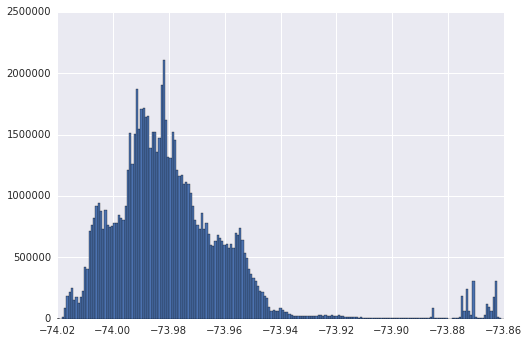

In [158]:
histBinsLo = np.linspace(-74.02,-73.86,200)
df['pickup_longitude'].hist(bins=histBinsLo)

Histogram latitude

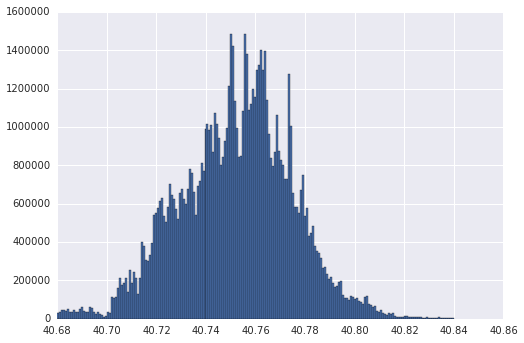

In [159]:
histBinsLa = np.linspace(40.68,40.84,200)
df['pickup_latitude'].hist(bins=histBinsLa)

Joint histogram of longitude and latitude

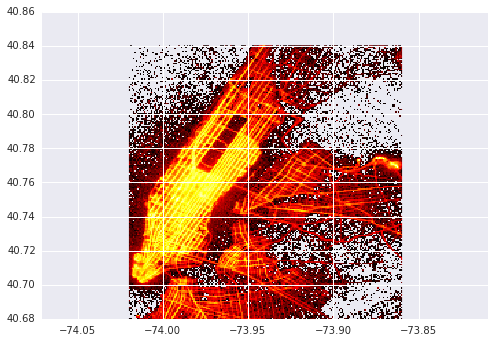

In [160]:
x = df['pickup_longitude'].values
y = df['pickup_latitude'].values
plt.hist2d(x,y,bins=[histBinsLo, histBinsLa],norm=matplotlib.colors.LogNorm(),cmap='hot')
limits = plt.axis('equal')

Load weather data and take a look

In [161]:
weather_df = pd.read_pickle('../WEATHER/clean_weather.pkl')
weather_df.head()

,Number,Time,AbsoluteDay,Month,DayOfMonth,DayOfWeek,Hour,TemperatureF,PrecipitationIn,Humidity,SeaLevelPressureIn,VisibilityMPH,Conditions,WindSpeedMPH
0,0,2013-07-01 00:00:00,0,7,1,0,0,73.9,NaN,87,29.91,9,Clear,3.5
1,1,2013-07-01 01:00:00,0,7,1,0,1,75.0,NaN,84,29.92,8,Overcast,0.0
2,2,2013-07-01 02:00:00,0,7,1,0,2,75.0,NaN,84,29.92,8,Overcast,0.0
3,3,2013-07-01 03:00:00,0,7,1,0,3,73.9,NaN,87,29.91,8,Overcast,3.5
4,4,2013-07-01 04:00:00,0,7,1,0,4,73.9,NaN,87,29.91,9,Overcast,0.0


[]

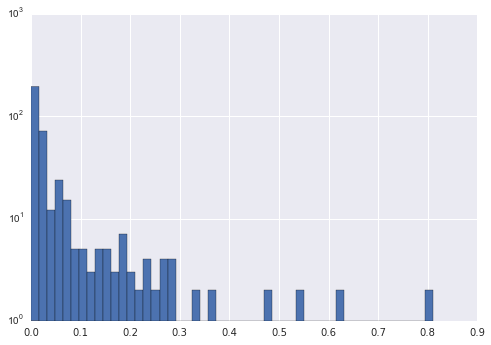

In [162]:
weather_df['PrecipitationIn'].hist(bins=50, bottom = 1)
plt.semilogy()

Rearrange the data to match the taxi dataset and merge the two

In [163]:
weather_df['AbsoluteDay'] = weather_df['AbsoluteDay'] + 182 #to bring both dataframes to the same scale
weather_df.drop(['Time','Number'],axis=1,inplace=True) #don't need these
#make columns match in both dataFrames
weather_df.rename(columns={'AbsoluteDay':'pickup_day_of_year', 'Month':'pickup_month',
                           'DayOfMonth':'pickup_day_of_Month','DayOfWeek':'pickup_day_of_week',
                           'Hour':'pickup_hour'}, inplace=True)
weather_df['PrecipitationIn'].fillna(0, inplace=True) #I'm assuming NaNs are no percip
weather_df['rain'] = weather_df['Conditions'].map(lambda x: 'Rain' in x)
joint_df = pd.merge(df, weather_df)

Make a dataFrame of only weekday data

In [164]:
weekday_df = joint_df[['pickup_day_of_year','passenger_count','trip_time_in_secs','trip_distance','pickup_hour','rain']][joint_df['pickup_day_of_week']<5]

Group the data s.t. we have the average number of trips per hour (across days) separated into rainy and non-rainy days

In [165]:
grp = weekday_df.groupby(['pickup_hour', 'rain', 'pickup_day_of_year']).count() #the count will get us number of trips

In [166]:
grp.index = grp.index.droplevel(2) #don't really care about day of year
grp = grp.groupby(level=[0,1]).mean()
grp.head()

passenger_count  trip_time_in_secs  trip_distance
pickup_hour rain                                                    
0           False     14674.539062       14674.539062   14674.437500
            True      14795.750000       14795.750000   14798.000000
1           False      9260.584615        9260.584615    9260.523077
            True       7943.500000        7943.500000    7944.000000
2           False      6077.085938        6077.085938    6076.984375

In [167]:
tripCount = grp['passenger_count'].unstack()

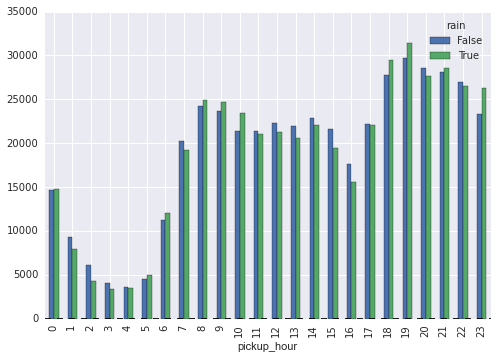

In [168]:
tripCount.plot(kind='bar')